This notebook is used to guess the location of a google streetview image. AI predictions are printed on a map.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow
import torch
import keras

In [6]:
#model = keras.models.load_model('Backups/V3_MODEL (Good)/Backup_5')
model = keras.models.load_model('Backups/Backup_6')

In [7]:
min_lat = 25.84
max_lat = 49.38
min_lon = -124.67
max_lon = -66.95

n_lats = len(np.unique(np.round(np.arange(min_lat, max_lat, 0.01))))
n_lons = len(np.unique(np.round(np.arange(min_lon, max_lon, 0.01))))

def center_crop(img, new_width=None, new_height=None):        

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def coord_to_onehot(coord):
    #Coordinate should be in [lat, lon] format
    lat = round(coord[0]) - round(min_lat)
    lon = abs(round(coord[1]) - round(min_lon))
    return (lat * n_lons) + lon

def onehot_to_coord(value):
    lon = value % n_lons
    lat = round((value - lon)/n_lons)
    return [round(lat) + round(min_lat), round(lon) + round(min_lon)]

def denormalize(coords):
    coordCopy = np.copy(coords)
    coordCopy[:,0] = (coordCopy[:,0] * n_lats) + min_lat
    coordCopy[:,1] = (coordCopy[:,1] * n_lons) + min_lon
    return coordCopy

def map_pred_categorical(pred, real=None):
    print(f'Prediction: {onehot_to_coord(np.argmax(pred))}')
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])

    m = Basemap(llcrnrlon=-120.211606,llcrnrlat=20.837377,urcrnrlon=-60.158958,urcrnrlat=50.384359,
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',area_thresh=1000.,projection='lcc',\
                lat_1=50,lon_0=-100.,ax=ax)

    
    m.drawmapboundary(fill_color='#0d0887')
    m.fillcontinents(color = '#0d0887',lake_color='#0d0887')

    lat, lon = np.meshgrid(np.linspace(round(min_lat), round(max_lat), n_lats), np.linspace(round(min_lon), round(max_lon), n_lons))
    lonm, latm = m(lon.reshape(-1), lat.reshape(-1))
    
    m.pcolormesh(lon, lat, np.transpose(pred.reshape(n_lats, n_lons)), latlon=True, zorder=2, cmap='plasma', shading='nearest')
    
    if real != None:
        lonm, latm = m(real[1], real[0])
        m.scatter(lonm, latm, marker = '*', c = '#00ff12', zorder=100, s=250, alpha=1)

    predictCoords = onehot_to_coord(np.argmax(pred))
    lonm, latm = m(predictCoords[1], predictCoords[0])
    m.scatter(lonm, latm, marker = '+', c = '#371784', zorder=100, s=250, alpha=1)
    
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    return fig
    
def map_pred_continuous(pred):
    pred = denormalize(pred)
    print(f'Prediction: {pred[0]}')
    if pred[0][0] < min_lat or pred[0][0] > max_lat or pred[0][1] < min_lon or pred[0][1] > max_lon:
        print('Invalid Output!')
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])

    m = Basemap(llcrnrlon=-120.211606,llcrnrlat=20.837377,urcrnrlon=-60.158958,urcrnrlat=50.384359,
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',area_thresh=1000.,projection='lcc',\
                lat_1=50,lon_0=-100.,ax=ax)

    
    m.drawmapboundary(fill_color='#0d0887')
    m.fillcontinents(color = '#0d0887',lake_color='#0d0887')
    
    lonm, latm = m(pred[0][1], pred[0][0])
    m.scatter(lonm, latm, marker = '*', c = '#00ff12', zorder=100, s=100, alpha=1)
    
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    #return fig

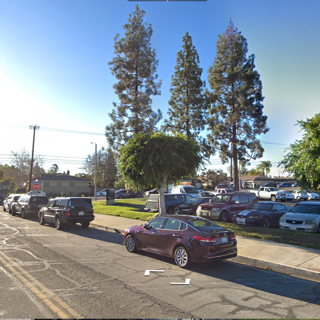

In [22]:
img = Image.open('Games/loc4.png').convert("RGB")
img = Image.fromarray(center_crop(np.array(img)))
img = img.resize((320,320))
img

Prediction: [41, -121]


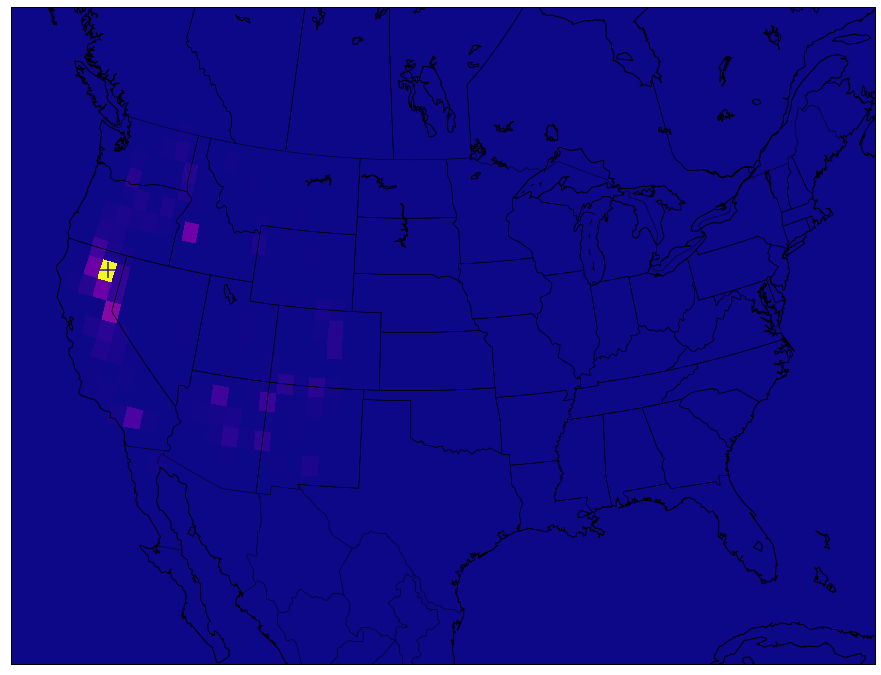

In [23]:
fig = map_pred_categorical(model.predict(preprocess_input(np.array([np.array(img)]))))